In [64]:
import numpy as np
import matplotlib.pyplot as plt

Q5: 这里应该用n*p来看1的个数，数个数 还有应该证明他们是uncorrelated(将0换成-1)

In [65]:
def source(n,p):
    "n: number of length; P: probability"
    # Generate N uniform random variable
    u = np.random.rand(n)
    # u<p, ture;otherwise false
    b = (u < p).astype(int)
    return b
# TEST
if __name__ == "__main__":
    test_bits = source(1024, 0.5)
    print(f"the first 20 bits: {test_bits[:20]}")
    print(f"mean value of the bits: {np.mean(test_bits)} ")

the first 20 bits: [1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 0 1]
mean value of the bits: 0.4970703125 


Q6

In [66]:
def prbs_source(N):
    """
    使用 LFSR 生成长度为 N 的伪随机序列 (PRBS-7)。
    多项式: x^7 + x^6 + 1
    """
    # 初始化寄存器 (7位，初始不能全为0)
    register = [1, 1, 1, 1, 1, 1, 1]
    b = np.zeros(N, dtype=int)

    for i in range(N):
        # 取出输出位 (通常取最后一个)
        out = register[-1]
        b[i] = out

        # 计算反馈位: tap 6 XOR tap 7 (索引 5 和 6)
        feedback = register[5] ^ register[6]

        # 移位操作: 插入反馈位到头部，移除尾部
        register = [feedback] + register[:-1]

    return b

！Q7 这一问还需要解释一下constellation为什么是-3 -1 1 3;hamming distance =1的好处是即使SER不好，BER也不会太差，就一个bit错了;


老师这里的格式是mapper(b,const,mapping):const是星座图、mapping是dictionary，比如0000对应-3-3i

Recursive, divide by 4.

In [67]:
def mapper(b):
    """
    Map bits to symbols.
    Parameters:
        b: input bit array
    Returns:
        s: complex symbol array
    """
    # 1. Check bit length
    if len(b) % 4 != 0:
        raise ValueError("The number of bits must be a multiple of 4 (for 16-QAM)")

    # 2. Reshape bits into an (N/4, 4) matrix
    # Each row represents 4 bits of one symbol: [b0, b1, b2, b3]
    n_syms = len(b) // 4
    bits_matrix = b.reshape(n_syms, 4)

    # 3. Separate real-part bits and imaginary-part bits
    # The first two columns are for the real part
    bits_real = bits_matrix[:, 0:2]
    # The last two columns are for the imaginary part
    bits_imag = bits_matrix[:, 2:4]

    # 4. Convert binary to decimal indices (0, 1, 2, 3)
    # e.g., [1, 0] -> 1*2 + 0*1 = 2
    # This step is prepared for the look-up table
    idx_real = bits_real[:, 0] * 2 + bits_real[:, 1]
    idx_imag = bits_imag[:, 0] * 2 + bits_imag[:, 1]

    # 5. Define the mapping table
    # Index: 0(00), 1(01), 2(10), 3(11)
    # Value: -3,    -1,    +3,    +1
    mapping_table = np.array([-3, -1, 3, 1])

    # 6. Look up coordinate values
    real_parts = mapping_table[idx_real]
    imag_parts = mapping_table[idx_imag]

    # 7. Combine into complex numbers
    s = real_parts + 1j * imag_parts

    # 8. Calculate average energy
    E = np.mean(np.abs(s)**2)
    print(f"Average Energy E = {E}")

    return s

Average Energy E = 9.40625


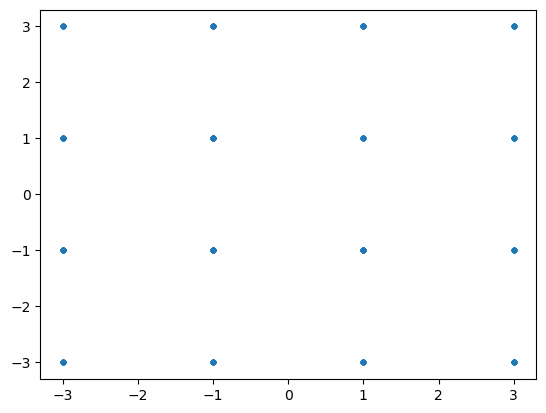

In [68]:
b = source(1024, 0.5)
s = mapper(b)
plt.plot(np.real(s),np.imag(s),".")

Q8 证明

Q9 课堂sinc 回家RRC; e.g. B=2

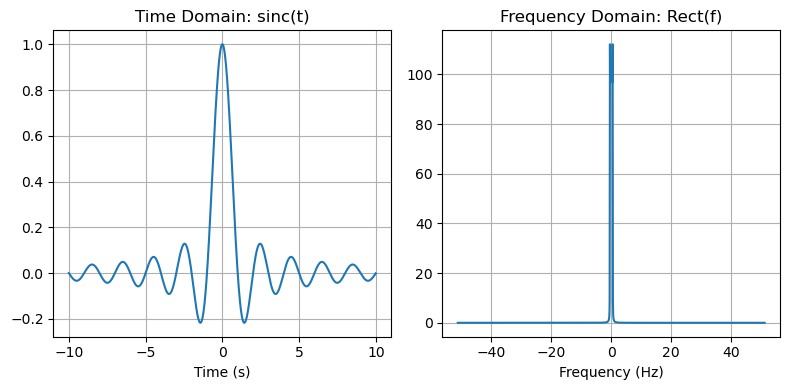

In [69]:
T = 20 # Time window
N = 2 ** 11 # Num of sampling points
dt = T / N # Step size of time
t = np.arange(-T/2, T/2, dt)
F = 1 / dt
df = 1/ T
f = np.arange(-N/2, N/2) * df
y = np.sinc(t)
Y = np.fft.fft(y)
Y_shifted = np.fft.fftshift(Y)
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(t, y)
plt.title("Time Domain: sinc(t)")
plt.xlabel("Time (s)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(f, np.abs(Y_shifted))
plt.title("Frequency Domain: Rect(f)")
plt.xlabel("Frequency (Hz)")
plt.grid(True)
plt.tight_layout()
plt.show()

B = 2
def mod_sinc(s,t,B=2):
    '''
    :param s: symbol array
    :param B: bandwidth
    :param t: time
    :return: q
    '''
    q_t = np.zeros(len(t), dtype=complex)

    Ns = len(s)           # 符号数量
    center_index = Ns // 2 # 符号中心索引，用于让符号序列在时间轴 t=0 处居中

    # 叠加每个符号的波形
    # 公式: q(t) = sum( s[l] * p(t - l*Ts) )
    # 其中 Ts = 1/B, p(t) = sqrt(B) * sinc(Bt)
    for i in range(Ns):
        # l 是相对中心的索引 (例如: -2, -1, 0, 1, 2)
        l = i - center_index

        # 计算时移: t_shifted = t - l * Ts = t - l/B
        t_shifted = t - (l / B)

        # 生成单位能量的 Sinc 脉冲
        # np.sinc(x) 计算的是 sin(pi*x)/(pi*x)
        pulse = np.sqrt(B) * np.sinc(B * t_shifted)

        # 累加到总信号
        q_t += s[i] * pulse

    return q_t

q_sinc = mod_sinc(s,t)


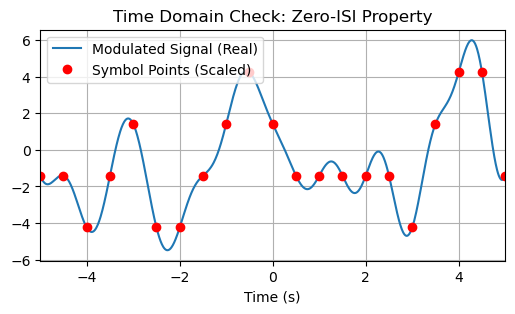

In [70]:
# 时域检查
plt.figure(figsize=(6, 3))

# 1. 画出调制后的连续波形 (实部)
plt.plot(t, q_sinc.real, label='Modulated Signal (Real)')

# 2. 标出理论上的符号点
# 计算每个符号对应的时刻: t = l * Ts = l / B
Ns = len(s)
center_index = Ns // 2
symbol_times = (np.arange(Ns) - center_index) / B

# 注意：你的脉冲乘以了 sqrt(B)，所以理论值也要乘以 sqrt(B) 才能对上
expected_values = s.real * np.sqrt(B)

# 画红点
plt.plot(symbol_times, expected_values, 'ro', label='Symbol Points (Scaled)')

plt.title("Time Domain Check: Zero-ISI Property")
plt.xlabel("Time (s)")
plt.grid(True)
plt.legend()
plt.xlim([-5, 5]) # 放大看中心区域
plt.show()

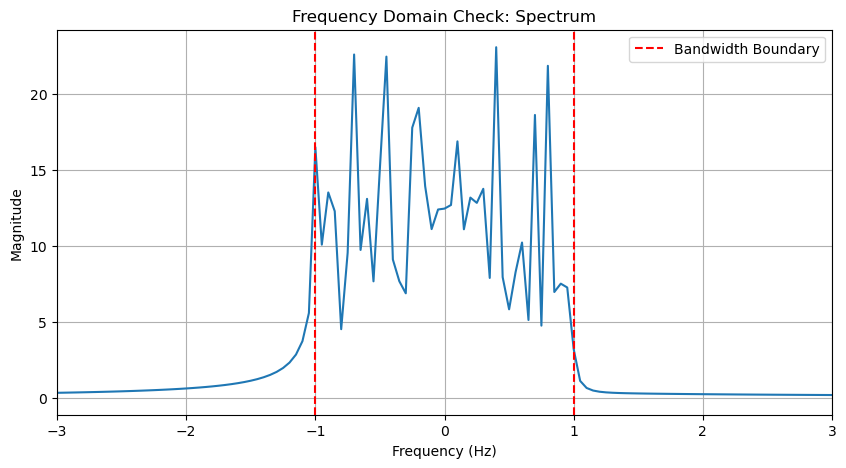

In [71]:
# 频域检查
Q_freq = np.fft.fftshift(np.fft.fft(q_sinc)) * dt # 归一化幅度

# 2. 画频谱幅度
plt.figure(figsize=(10, 5))
plt.plot(f, np.abs(Q_freq))

plt.title("Frequency Domain Check: Spectrum")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.grid(True)

# 标记出带宽边界 -B/2 和 B/2
plt.axvline(-B/2, color='r', linestyle='--', label='Bandwidth Boundary')
plt.axvline(B/2, color='r', linestyle='--')

plt.xlim([-3, 3]) # 放大看中心，应该看到宽度为 B=2 的方波
plt.legend()
plt.show()

需要证明RRC的正交性

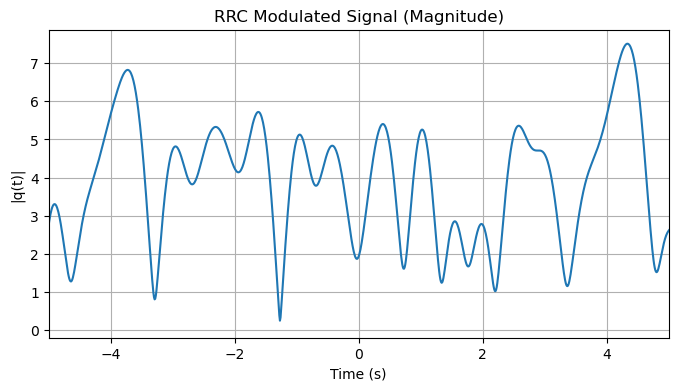

In [72]:
# RRC
def pulse_RRC(t, B, r=0.3):
    """
    生成根升余弦脉冲 (Root Raised Cosine Pulse)
    :param t: 时间向量
    :param B: 带宽 (符号率 Rs)
    :param r: 滚降系数 (通常 0.3)
    :return: 脉冲波形 h(t)
    """
    # 1. 防止分母为 0 的 "Epsilon Trick"
    # 给时间加一个极小值，避免数学奇点
    t_safe = t + 1e-14

    Ts = 1.0 / B

    # 2. RRC 公式 (标准定义)
    # 为了公式清晰，定义 x = t / Ts
    x = t_safe / Ts

    # 分子 (Numerator)
    # sin( pi*(1-r)*x ) + 4*r*x * cos( pi*(1+r)*x )
    numer = np.sin(np.pi * (1 - r) * x) + \
            (4 * r * x) * np.cos(np.pi * (1 + r) * x)

    # 分母 (Denominator)
    # pi*x * (1 - (4*r*x)^2)
    denom = (np.pi * x) * (1 - (4 * r * x)**2)

    # 3. 计算并归一化
    # 乘以 1/sqrt(Ts) 也就是 sqrt(B) 以保证单位能量
    h = (1 / np.sqrt(Ts)) * (numer / denom)

    return h

def mod_rrc(s, t, B=2, r=0.3):
    """
    RRC 专用调制器
    参数:
        s: 符号序列 (复数)
        t: 时间轴
        B: 带宽 (默认为2)
        r: 滚降系数 (默认为0.3)
    返回:
        q_t: 调制后的信号
    """
    q_t = np.zeros(len(t), dtype=complex)

    Ns = len(s)
    center_index = Ns // 2

    # 循环叠加每个符号
    for i in range(Ns):
        # 计算相对索引 l
        l = i - center_index

        # 计算时移: t - l/B
        t_shifted = t - (l / B)

        # === 关键点：这里直接调用 RRC 脉冲函数 ===
        pulse = pulse_RRC(t_shifted, B, r)

        # 叠加
        q_t += s[i] * pulse

    return q_t

q_rrc = mod_rrc(s,t,B=2,r=0.3)
# 检查
plt.figure(figsize=(8, 4))

# 画波形幅度 (Abs)
plt.plot(t, np.abs(q_rrc))

plt.title("RRC Modulated Signal (Magnitude)")
plt.xlabel("Time (s)")
plt.ylabel("|q(t)|")
plt.grid(True)
plt.xlim([-5, 5])
plt.show()

Q12 channel： 课件55、57、58 L=2000km, $\epsilon = 2$km，先做dispersion部分：检验的话检查能量（能量应当不变），也可以用高斯脉冲检查，def linear_step(q,t0,t,beta2,z) return q_linear

In [73]:
def linear_step(q_t0, t, beta2, z):
    """
    计算线性传输步 (Linear Step)，仅考虑色散 (Dispersion)。

    参数:
        q_t0  : 输入的时域信号数组 (复数)
        t     : 时间轴数组 (用于计算频率 omega)
        beta2 : 色散参数 (例如 ps^2/km)
        z     : 这一步的传输距离 (km)

    返回:
        q_out : 传输 z 距离后的时域信号
    """

    # 1. 获取时间轴信息
    N = len(t)
    dt = t[1] - t[0]

    # 2. 生成频率轴 omega
    # 使用 fftfreq 自动生成符合 FFT 顺序的频率: [0, 1, ..., -N/2, ..., -1]
    # 这样不需要手动 fftshift，直接对应 FFT 的输出结果
    f = np.fft.fftfreq(N, d=dt)
    omega = 2 * np.pi * f

    # 3. 转换到频域 (FFT)
    Q_w = np.fft.fft(q_t0)

    # 4. 构建色散算子 (Dispersion Operator)
    # 理论公式: A(z, w) = A(0, w) * exp( j * (beta2/2) * omega^2 * z )
    # 注意: 这里忽略了 alpha (衰减)
    dispersion_op = np.exp(1j * (beta2 / 2) * (omega**2) * z)

    # 5. 频域相乘 (应用色散)
    Q_out_w = Q_w * dispersion_op

    # 6. 转换回时域 (IFFT)
    q_out = np.fft.ifft(Q_out_w)

    return q_out

energy in: 1.772454
energy out: 1.772454


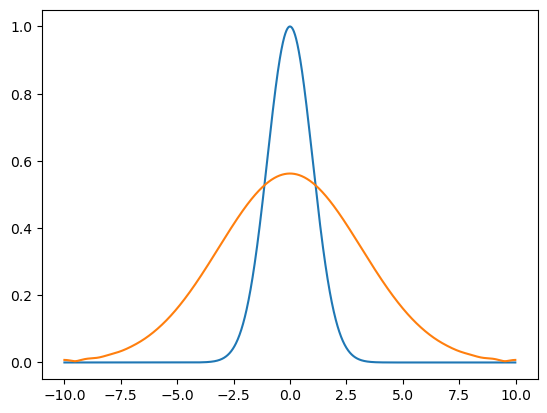

In [81]:
# TEST
q_0 = np.exp(-t ** 2 / 2)
q_out = linear_step(q_0,t,1,3)
energy_in = np.sum(np.abs(q_0)**2) * dt
energy_out = np.sum(np.abs(q_out)**2) * dt
plt.plot(t,q_0)
plt.plot(t,np.abs(q_out))
print(f"energy in: {energy_in:.6f}")
print(f"energy out: {energy_out:.6f}")


Non-linear part

In [87]:
def nonlinear_step(q, gamma, h, alpha=0):
    """
    计算非线性传输步 (Non-linear Step / SPM)。

    参数:
        q     : 时域信号 (复数数组)
        gamma : 非线性系数 (1/(W*km))
        h     : 这一步的步长 (km)
        alpha : 衰减系数 (1/km)，默认为0 (不考虑步内衰减)

    返回:
        q_out : 经过非线性相位旋转后的信号
    """

    # 1. 计算瞬时功率 Power = |Amplitude|^2
    power = np.abs(q)**2

    # 2. 计算有效长度 Leff
    # 如果 alpha 接近 0，Leff 就是 h；否则用公式
    if alpha < 1e-9:
        Leff = h
    else:
        Leff = (1 - np.exp(-alpha * h)) / alpha

    # 3. 计算非线性相移 phi = gamma * P * Leff
    # 这是一个纯相位项 (Pure Phase Shift)
    nonlinear_phase = gamma * power * Leff

    # 4. 应用相移 (乘以 exp(j * phi))
    # 注意: SPM 通常导致相位滞后，但在 NLSE 标准形式中，
    # 算子通常写为 exp(j * gamma * |A|^2 * z)
    q_out = q * np.exp(1j * nonlinear_phase)

    return q_out


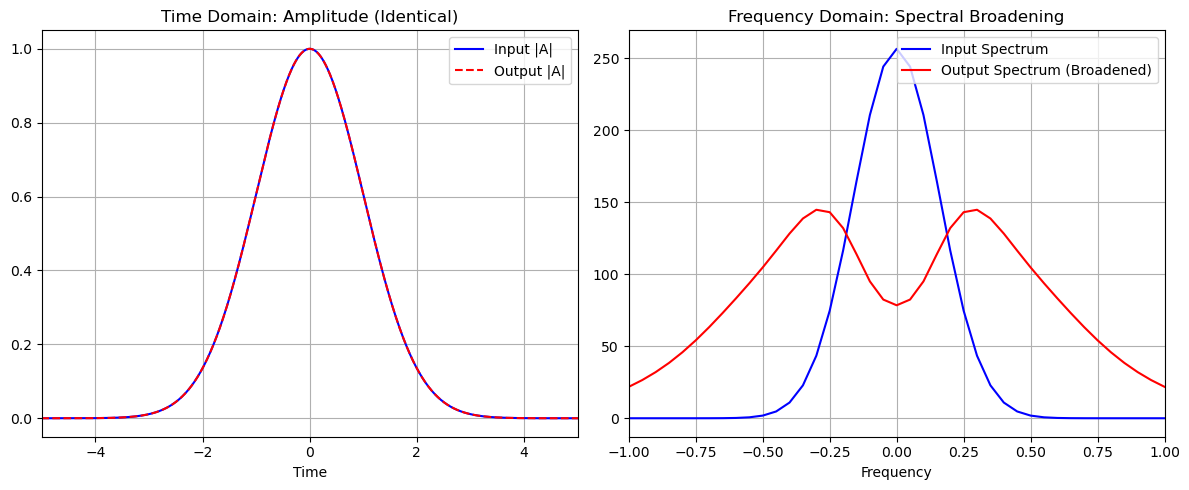

In [98]:
# TEST
q_out_nl = nonlinear_step(q_0,1,4,0)
# 频域转换
# 计算频率轴
f = np.fft.fftfreq(N, d=dt)
f_shifted = np.fft.fftshift(f)
# 计算频谱 (FFT) 并移位
Q_0 = np.fft.fftshift(np.fft.fft(q_0))
Q_out_nl = np.fft.fftshift(np.fft.fft(q_out_nl))

plt.figure(figsize=(12, 5))
# 子图1: 时域幅度 (确认能量守恒)
plt.subplot(1, 2, 1)
plt.plot(t, np.abs(q_0), 'b', label='Input |A|')
plt.plot(t, np.abs(q_out_nl), 'r--', label='Output |A|')
plt.title("Time Domain: Amplitude (Identical)")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.xlim([-5, 5])
# 子图2: 频域频谱 (观察展宽)
plt.subplot(1, 2, 2)
# 画幅度谱 (取对数看 dB 也可以，这里先看线性幅度)
plt.plot(f_shifted, np.abs(Q_0), 'b', label='Input Spectrum')
plt.plot(f_shifted, np.abs(Q_out_nl), 'r', label='Output Spectrum (Broadened)')
plt.title("Frequency Domain: Spectral Broadening")
plt.xlabel("Frequency")
plt.legend()
plt.grid(True)
plt.xlim([-1, 1]) # 放大看中心区域
plt.tight_layout()
plt.show()


Q18 Demodulation: def demod(x,dt,B) error = $\frac{\|s-\hat{s}\|}{(\|s\|+\|\hat{s}\|)/2}$


In [75]:
def demod(t, qzte, B, Ns):
    """
    解调器 (Demodulator)
    通过匹配滤波 (Matched Filtering) 从波形中恢复符号。
    参数:
        t: 时间向量
        qzte: 接收到的信号 (经过均衡处理后的)
        B: 带宽
        Ns: 符号数量 (必须知道要恢复多少个符号)
    返回:
        shat: 恢复出的符号序列 (估计值)
    """
    # 1. 初始化输出数组 (复数)
    shat = np.zeros(Ns, dtype=complex)

    # 2. 计算积分的时间步长 dt
    dt = t[1] - t[0]

    # 3. 确定中心索引 (必须与 Modulator 的逻辑完全一致)
    center_index = Ns // 2

    # 4. 逐个恢复符号
    for i in range(Ns):
        # 计算当前的符号索引 l (例如 -2, -1, 0, 1, 2)
        l = i - center_index

        # === 构建匹配滤波器 (Matched Filter) ===
        # 这一步必须和发送端(Modulator)用的脉冲一模一样！
        # 发送端用了 sqrt(B)*sinc，这里也用 sqrt(B)*sinc
        # 这样根据正交性，积分结果就是 s 本身

        t_shifted = t - (l / B)
        matched_pulse = np.sqrt(B) * np.sinc(B * t_shifted)

        # === 投影 (积分) ===
        # 连续积分 int(x(t) * p(t) dt) 在离散中近似为 sum(x * p) * dt
        # 这里的点乘是 element-wise multiplication (对应点相乘)
        shat[i] = np.sum(qzte * matched_pulse) * dt

    return shat
s_hat = demod(t,q_sinc,B,Ns)

# 4. 验证结果
print("原始符号 (前5个):", s[:5])
print("恢复符号 (前5个):", s_hat[:5])

error = np.linalg.norm(s - s_hat) / ((np.linalg.norm(s) + np.linalg.norm(s_hat)) / 2)
print(f"error: {error:.6e}")

原始符号 (前5个): [-1.+1.j -3.-3.j  3.-3.j -3.-3.j -1.-3.j]
恢复符号 (前5个): [-0.00071256+0.03193896j  0.00072152-0.03219472j -0.00073069+0.03245464j
  0.00074009-0.03271883j -0.00074972+0.0329874j ]
error: 1.342105e+00
